# This a baseline model
It is copied from: https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
<br>
Based on the notebook: https://www.kaggle.com/code/uzdavinys/drw-cypto-time-series-cross-validation-examples, it appears that using k-fold with shuffling could yield better LB score.

## 📌 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import shap

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import pickle
import os
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 📂 2. Load Dataset

The following technique/code is adapted from Kaggle Master Mahdi Ravaghi’s work.
You can find more details in his original [notebook](https://www.kaggle.com/code/ravaghi/drw-crypto-market-prediction-ensemble).

In [2]:
class CFG:
    main_path = "/Users/Sigrid/Desktop/drw-crypto-market-prediction"
    train_path = "/Users/Sigrid/Desktop/drw-crypto-market-prediction/train.parquet"
    test_path = "/Users/Sigrid/Desktop/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/Users/Sigrid/Desktop/drw-crypto-market-prediction/sample_submission.csv"

In [3]:
def save_model(model, path):
    with open(path, "wb") as f:
        pickle.dump(model, f)


def load_model(path):
    with open(path, "rb") as f:
        model = pickle.load(f)
    return model

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
train_orig0 = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test_orig0 = pd.read_parquet(CFG.test_path).reset_index(drop=True)
sample = pd.read_csv(CFG.sample_sub_path)

In [6]:
train_orig = reduce_mem_usage(train_orig0, 'train')
test_orig = reduce_mem_usage(test_orig0, 'test')

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [49]:
train_orig.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,15.281250,8.421875,176.3750,44.96875,221.375,0.121277,-0.417725,0.005398,0.125977,0.058350,...,1.925781,1.847656,0.005676,0.190796,0.369629,0.377686,0.210205,0.159180,0.530762,0.562500
1,38.593750,2.335938,526.0000,322.00000,848.000,0.302734,-0.049561,0.356689,0.481201,0.237915,...,1.928711,1.849609,0.005226,0.184692,0.363525,0.374512,0.209595,0.158936,0.530273,0.533691
2,0.441895,60.250000,159.2500,136.37500,295.500,0.167480,-0.291260,0.083130,0.206909,0.101746,...,1.927734,1.849609,0.004795,0.178711,0.357666,0.371338,0.208984,0.158691,0.529785,0.546387
3,4.863281,21.015625,335.7500,124.93750,460.750,0.072937,-0.436523,-0.102478,0.017548,0.007149,...,1.928711,1.849609,0.004398,0.172974,0.351807,0.368408,0.208374,0.158569,0.529297,0.357666
4,27.156250,3.451172,98.4375,44.40625,142.875,0.173828,-0.213501,0.096069,0.215698,0.107117,...,1.926758,1.848633,0.004009,0.167358,0.345947,0.365234,0.207886,0.158325,0.529297,0.362549


In [50]:
test_orig.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,0.114014,12.117188,10.585938,10.968750,21.5625,-0.732910,0.512207,-0.041992,-0.598145,-0.517578,...,1.014648,1.367188,1.583984,1.583984,1.583984,1.583984,1.568359,1.426758,2.193359,0.0
1,2.425781,2.962891,136.250000,12.304688,148.5000,-0.337891,-0.412109,-0.259521,-0.334717,-0.247437,...,1.749023,1.848633,0.000131,0.000323,0.001746,0.007320,0.050934,0.142212,0.739746,0.0
2,1.084961,2.343750,23.390625,57.156250,80.5625,0.111267,0.458252,0.466797,0.574219,0.324707,...,1.705078,1.772461,0.000550,0.003597,0.009262,0.019943,0.072510,0.169678,0.808105,0.0
3,14.796875,1.117188,116.500000,13.078125,129.6250,-0.149414,-0.640625,-0.873535,-1.026367,-0.508789,...,0.931152,1.038086,1.381836,1.381836,1.381836,1.381836,1.381836,1.363281,2.464844,0.0
4,0.032990,14.179688,43.812500,49.843750,93.6250,-0.694824,0.611328,0.067688,-0.531738,-0.581543,...,1.080078,1.141602,0.000363,0.012718,0.137573,0.464111,1.050781,1.268555,2.498047,0.0


## 📊 3. Selected Features Based on SHAP Values

In [26]:
selected_features = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]

train = train_orig[selected_features + ["label"]].copy()
test = test_orig[selected_features].copy()

In [11]:
print("Train=",train.shape)
print("Test=",test.shape)
print("Sample=",sample.shape)

Train= (525887, 26)
Test= (538150, 25)
Sample= (538150, 2)


In [27]:
RMV = ["label"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 25 FEATURES: ['X863', 'X856', 'X344', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860', 'X674', 'X415', 'X345', 'X137', 'X855', 'X174', 'X302', 'X178', 'X532', 'X168', 'X612', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']


## 🚀 4. Train XGBoost with KFold Cross-Validation

In [29]:
xgb_params = {
    "tree_method": "hist",
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0,
    "early_stopping_rounds":25
}

In [14]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))



for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print("#" * 25)
    print(f"### Fold {i + 1}")
    print("#" * 25)

    X_train = train.iloc[train_idx][FEATURES]
    y_train = train.iloc[train_idx]["label"]
    X_valid = train.iloc[valid_idx][FEATURES]
    y_valid = train.iloc[valid_idx]["label"]
    X_test = test[FEATURES]

    model = XGBRegressor(**xgb_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=200
    )

    oof_preds[valid_idx] = model.predict(X_valid)
    test_preds += model.predict(X_test)

pearson_score = pearsonr(train["label"], oof_preds)[0]
print("Final Pearson Correlation = ", pearson_score)

test_preds /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:1.01619
[200]	validation_0-rmse:0.98709
[400]	validation_0-rmse:0.96932
[600]	validation_0-rmse:0.95563
[800]	validation_0-rmse:0.94431
[1000]	validation_0-rmse:0.93459
[1200]	validation_0-rmse:0.92570
[1400]	validation_0-rmse:0.91806
[1600]	validation_0-rmse:0.91093
[1666]	validation_0-rmse:0.90861
#########################
### Fold 2
#########################
[0]	validation_0-rmse:1.01403
[200]	validation_0-rmse:0.98552
[400]	validation_0-rmse:0.96717
[600]	validation_0-rmse:0.95337
[800]	validation_0-rmse:0.94197
[1000]	validation_0-rmse:0.93245
[1200]	validation_0-rmse:0.92375
[1400]	validation_0-rmse:0.91658
[1600]	validation_0-rmse:0.90951
[1666]	validation_0-rmse:0.90793
#########################
### Fold 3
#########################
[0]	validation_0-rmse:1.00231
[200]	validation_0-rmse:0.97389
[400]	validation_0-rmse:0.95682
[600]	validation_0-rmse:0.94328
[800]	validation_0-rmse:0.93244
[1000]	

In [43]:
save_model(model, os.path.join(CFG.main_path, 'XGB_baseline'))

## 📌 5. SHAP Explainability

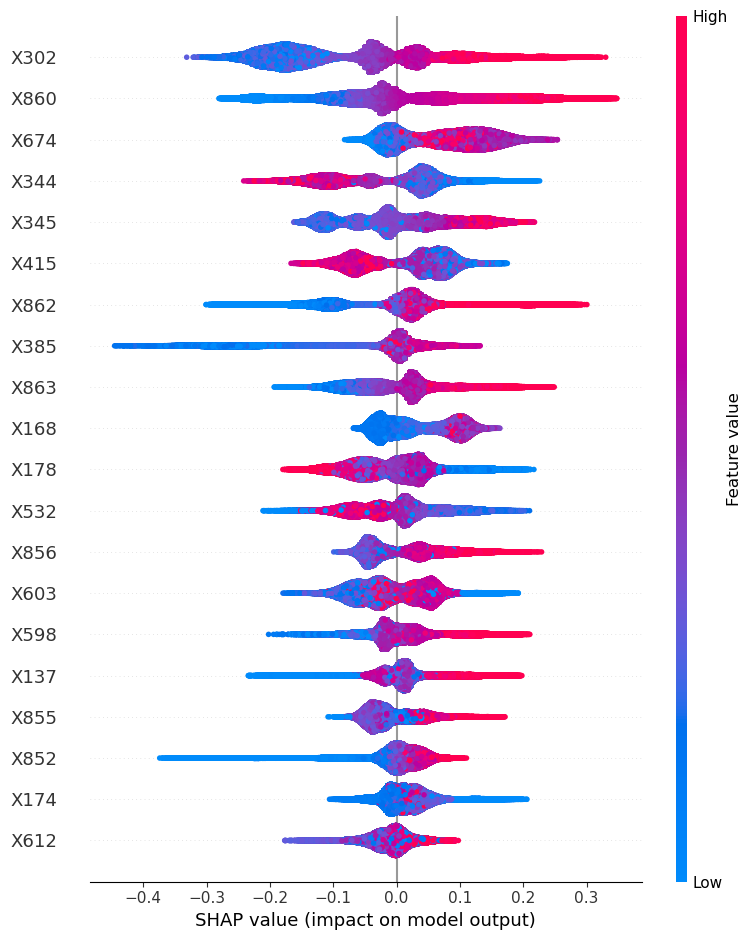

In [15]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent", model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## 📤 6. Create Submission File

In [19]:
sample["prediction"] = test_preds
sample.to_csv("submission.csv", index=False)
sample.head()

,ID,prediction
0,1,0.148023
1,2,0.027944
2,3,0.215511
3,4,-0.128771
4,5,0.264123


# Some thoughts gained in other notebooks and discussion
1. Could add time decay: https://www.kaggle.com/code/elainedazzio/20250531-drw
2. try lightGBM
3. add other features: /Users/Sigrid/Desktop/drw-crypto-market-prediction
4. HMM for market regime detection: https://www.kaggle.com/code/digantabhattacharya/drw-regime-detection-using-hmm-step-1

## 1. Add time decay for the baseline model
Ensemble model gives a public score of 0.09798 (Submission1_1.csv), which is worse than baseline model (i.e. without time decay is better).

In [8]:
# Create time-based sample weights
def create_time_weights(n_samples, decay_factor=0.95):
    """
    Create exponentially decaying weights based on sample position.
    More recent samples (higher indices) get higher weights.
    decay_factor controls the rate of decay (0.95 = 5% decay per time unit)
    """
    positions = np.arange(n_samples)
    # Normalize positions to [0, 1] range
    normalized_positions = positions / (n_samples - 1)
    # Apply exponential weighting
    weights = decay_factor ** (1 - normalized_positions)
    # Normalize weights to sum to n_samples (maintains scale)
    weights = weights * n_samples / weights.sum()
    return weights

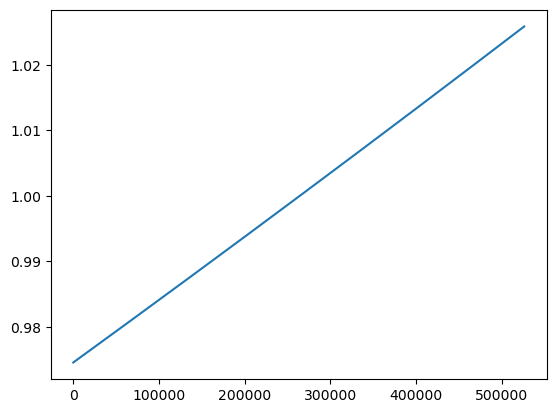

In [12]:
sample_weights_full = create_time_weights(len(train), decay_factor=0.95)

plt.plot([x for x in range(len(sample_weights_full))], sample_weights_full)

In [24]:
recent_percent = 0.4
cutoff_idx = int(len(train) * (1 - recent_percent))
print(f"Using most recent {len(train) - cutoff_idx} samples ({int(recent_percent*100)}% of data)")
train_recent = train.iloc[cutoff_idx:].copy()
train_recent.reset_index(drop=True, inplace=True)
sample_weights = create_time_weights(len(train_recent), decay_factor=0.95)

Using most recent 210355 samples (40% of data)


In [30]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds1 = np.zeros(len(train_recent))
test_preds1 = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(kf.split(train_recent)):
    print("#" * 25)
    print(f"### Fold {i + 1}")
    print("#" * 25)

    X_train = train_recent.iloc[train_idx][FEATURES]
    y_train = train_recent.iloc[train_idx]["label"]
    X_valid = train_recent.iloc[valid_idx][FEATURES]
    y_valid = train_recent.iloc[valid_idx]["label"]
    X_test = test[FEATURES]
    train_sample_weights = sample_weights[train_idx]
    
    model1 = XGBRegressor(**xgb_params)

    model1.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=200,
        sample_weight = train_sample_weights
    )

    oof_preds1[valid_idx] = model1.predict(X_valid)
    test_preds1 += model1.predict(X_test)

pearson_score = pearsonr(train_recent["label"], oof_preds1)[0]
print("Final Pearson Correlation = ", pearson_score)

test_preds1 /= FOLDS
save_model(model1, os.path.join(CFG.main_path, 'XGB_baseline_td'))

#########################
### Fold 1
#########################
[0]	validation_0-rmse:1.04406
[200]	validation_0-rmse:0.99808
[400]	validation_0-rmse:0.96981
[600]	validation_0-rmse:0.94793
[800]	validation_0-rmse:0.93054
[1000]	validation_0-rmse:0.91745
[1200]	validation_0-rmse:0.90727
[1400]	validation_0-rmse:0.89869
[1600]	validation_0-rmse:0.89004
[1666]	validation_0-rmse:0.88846
#########################
### Fold 2
#########################
[0]	validation_0-rmse:1.02039
[200]	validation_0-rmse:0.97440
[400]	validation_0-rmse:0.94737
[600]	validation_0-rmse:0.92577
[800]	validation_0-rmse:0.90954
[1000]	validation_0-rmse:0.89705
[1200]	validation_0-rmse:0.88729
[1400]	validation_0-rmse:0.87833
[1600]	validation_0-rmse:0.87101
[1666]	validation_0-rmse:0.86892
#########################
### Fold 3
#########################
[0]	validation_0-rmse:1.02681
[200]	validation_0-rmse:0.98074
[400]	validation_0-rmse:0.95141
[600]	validation_0-rmse:0.92928
[800]	validation_0-rmse:0.91316
[1000]	

In [33]:
sample["prediction"] = test_preds1
sample.to_csv("submission1.csv", index=False)
sample.tail()

,ID,prediction
538145,538146,0.016847
538146,538147,-0.412789
538147,538148,0.037536
538148,538149,0.044385
538149,538150,0.201446


In [34]:
# Define model configurations
model_configs = [
    {"name": "Model 1 (100% Full Data)", "percent": 1.00},
    {"name": "Model 2 (90% Recent)", "percent": 0.90},
    {"name": "Model 3 (80% Recent)", "percent": 0.80},
    {"name": "Model 4 (70% Recent)", "percent": 0.70},
    {"name": "Model 5 (60% Recent)", "percent": 0.60},
    {"name": "Model 6 (50% Recent)", "percent": 0.50},
    {"name": "Model 7 (40% Recent)", "percent": 0.40}
]

# Initialize predictions for all models
n_models = len(model_configs)
oof_preds_all = [np.zeros(len(train)) for _ in range(n_models)]
test_preds_all = [np.zeros(len(test)) for _ in range(n_models)]

# Generate sample weights for Model 1 (full data)
sample_weights_full = create_time_weights(len(train), decay_factor=0.95)
print(f"\nModel 1 - Full data sample weights range: [{sample_weights_full.min():.4f}, {sample_weights_full.max():.4f}]")
print(f"Model 1 - Full data sample weights mean: {sample_weights_full.mean():.4f}")

# Calculate cutoffs for each model
cutoffs = []
for config in model_configs:
    if config["percent"] == 1.00:
        cutoffs.append(0)  # Full data starts from index 0
    else:
        cutoff_idx = int(len(train) * (1 - config["percent"]))
        cutoffs.append(cutoff_idx)
        print(f"\n{config['name']} - Using most recent {len(train) - cutoff_idx} samples ({int(config['percent']*100)}% of data)")


Model 1 - Full data sample weights range: [0.9746, 1.0259]
Model 1 - Full data sample weights mean: 1.0000

Model 2 (90% Recent) - Using most recent 473299 samples (90% of data)

Model 3 (80% Recent) - Using most recent 420710 samples (80% of data)

Model 4 (70% Recent) - Using most recent 368121 samples (70% of data)

Model 5 (60% Recent) - Using most recent 315533 samples (60% of data)

Model 6 (50% Recent) - Using most recent 262944 samples (50% of data)

Model 7 (40% Recent) - Using most recent 210355 samples (40% of data)


In [37]:
for fold_num, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print("\n" + "#" * 50)
    print(f"### Fold {fold_num + 1}")
    print("#" * 50)
    
    X_valid = train.iloc[valid_idx][FEATURES]
    y_valid = train.iloc[valid_idx]["label"]
    X_test = test[FEATURES]
    
    # Train each model
    for model_idx, (config, cutoff) in enumerate(zip(model_configs, cutoffs)):
        print(f"\n--- {config['name']} ---")
        
        if config["percent"] == 1.00:
            # Model 1: Full data with time weights
            X_train = train.iloc[train_idx][FEATURES]
            y_train = train.iloc[train_idx]["label"]
            
            # Extract sample weights for this fold's training data
            train_weights = sample_weights_full[train_idx]
            
        else:
            # Other models: Recent data subsets
            # Filter train indices to only include those from the recent data
            train_idx_recent = train_idx[train_idx >= cutoff]
            
            # Adjust indices to start from 0 for the recent subset
            train_idx_recent_adjusted = train_idx_recent - cutoff
            
            # Get the recent subset of training data
            train_recent = train.iloc[cutoff:].reset_index(drop=True)
            
            X_train = train_recent.iloc[train_idx_recent_adjusted][FEATURES]
            y_train = train_recent.iloc[train_idx_recent_adjusted]["label"]
            
            # Create time weights for the recent data subset
            sample_weights_recent = create_time_weights(len(train_recent), decay_factor=0.95)
            train_weights = sample_weights_recent[train_idx_recent_adjusted]

        modeli = XGBRegressor(**xgb_params)
    
        modeli.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=200,
            sample_weight = train_weights
        )

        # Make predictions
        if config["percent"] == 1.00:
            # Model 1 predicts for all validation indices
            oof_preds_all[model_idx][valid_idx] = modeli.predict(X_valid)
        else:
            # Other models: handle validation indices that might be outside their training range
            valid_idx_in_range = valid_idx[valid_idx >= cutoff]
            if len(valid_idx_in_range) > 0:
                X_valid_subset = train.iloc[valid_idx_in_range][FEATURES]
                oof_preds_all[model_idx][valid_idx_in_range] = modeli.predict(X_valid_subset)
            
            # For indices before cutoff, use Model 1 predictions
            valid_idx_out_range = valid_idx[valid_idx < cutoff]
            if len(valid_idx_out_range) > 0:
                oof_preds_all[model_idx][valid_idx_out_range] = oof_preds_all[0][valid_idx_out_range]
        
        test_preds_all[model_idx] += modeli.predict(X_test)

# Average test predictions across folds
for i in range(n_models):
    test_preds_all[i] /= FOLDS

# Calculate individual model scores
pearson_scores = []
for i, config in enumerate(model_configs):
    score = pearsonr(train["label"], oof_preds_all[i])[0]
    pearson_scores.append(score)

print("\n" + "=" * 50)
print("INDIVIDUAL MODEL PERFORMANCE")
print("=" * 50)
for config, score in zip(model_configs, pearson_scores):
    print(f"{config['name']} Pearson Correlation: {score:.4f}")


##################################################
### Fold 1
##################################################

--- Model 1 (100% Full Data) ---
[0]	validation_0-rmse:1.01619
[200]	validation_0-rmse:0.98693
[400]	validation_0-rmse:0.96872
[600]	validation_0-rmse:0.95557
[800]	validation_0-rmse:0.94429
[1000]	validation_0-rmse:0.93482
[1200]	validation_0-rmse:0.92594
[1400]	validation_0-rmse:0.91854
[1600]	validation_0-rmse:0.91199
[1666]	validation_0-rmse:0.91015

--- Model 2 (90% Recent) ---
[0]	validation_0-rmse:1.01619
[200]	validation_0-rmse:0.98896
[400]	validation_0-rmse:0.97152
[600]	validation_0-rmse:0.95844
[800]	validation_0-rmse:0.94814
[1000]	validation_0-rmse:0.93888
[1200]	validation_0-rmse:0.93067
[1400]	validation_0-rmse:0.92378
[1600]	validation_0-rmse:0.91792
[1666]	validation_0-rmse:0.91615

--- Model 3 (80% Recent) ---
[0]	validation_0-rmse:1.01629
[200]	validation_0-rmse:0.98900
[400]	validation_0-rmse:0.97247
[600]	validation_0-rmse:0.96085
[800]	validation_0-r

In [39]:
# Create ensemble predictions
# Simple average ensemble
ensemble_oof_preds = np.mean(oof_preds_all, axis=0)
ensemble_test_preds = np.mean(test_preds_all, axis=0)

# Calculate ensemble score
ensemble_pearson_score = pearsonr(train["label"], ensemble_oof_preds)[0]

print("\n" + "=" * 50)
print("ENSEMBLE PERFORMANCE")
print("=" * 50)
print(f"Ensemble (Equal Weight) Pearson Correlation: {ensemble_pearson_score:.4f}")

# Performance-weighted ensemble
total_score = sum(pearson_scores)
weights = [score / total_score for score in pearson_scores]

weighted_ensemble_oof = np.zeros(len(train))
weighted_ensemble_test = np.zeros(len(test))

for i in range(n_models):
    weighted_ensemble_oof += weights[i] * oof_preds_all[i]
    weighted_ensemble_test += weights[i] * test_preds_all[i]

weighted_ensemble_score = pearsonr(train["label"], weighted_ensemble_oof)[0]

print(f"\nWeighted Ensemble Performance:")
for config, weight in zip(model_configs, weights):
    print(f"  {config['name']} weight: {weight:.3f}")
print(f"  Weighted Ensemble Pearson Correlation: {weighted_ensemble_score:.4f}")

# Use the better ensemble for final predictions
if weighted_ensemble_score > ensemble_pearson_score:
    final_test_preds = weighted_ensemble_test
    print("\nUsing weighted ensemble for final predictions")
else:
    final_test_preds = ensemble_test_preds
    print("\nUsing simple average ensemble for final predictions")

# Save predictions
sample["prediction"] = final_test_preds
sample.to_csv("submission1_1.csv", index=False)
print("\nPredictions saved to submission1_1.csv")
print(sample.head())


ENSEMBLE PERFORMANCE
Ensemble (Equal Weight) Pearson Correlation: 0.5352

Weighted Ensemble Performance:
  Model 1 (100% Full Data) weight: 0.136
  Model 2 (90% Recent) weight: 0.140
  Model 3 (80% Recent) weight: 0.142
  Model 4 (70% Recent) weight: 0.144
  Model 5 (60% Recent) weight: 0.146
  Model 6 (50% Recent) weight: 0.146
  Model 7 (40% Recent) weight: 0.146
  Weighted Ensemble Pearson Correlation: 0.5355

Using weighted ensemble for final predictions



Generating SHAP analysis...
[0]	validation_0-rmse:1.01968
[200]	validation_0-rmse:0.99004
[400]	validation_0-rmse:0.97236
[600]	validation_0-rmse:0.95870
[800]	validation_0-rmse:0.94728
[1000]	validation_0-rmse:0.93700
[1200]	validation_0-rmse:0.92860
[1400]	validation_0-rmse:0.92080
[1600]	validation_0-rmse:0.91402
[1666]	validation_0-rmse:0.91190


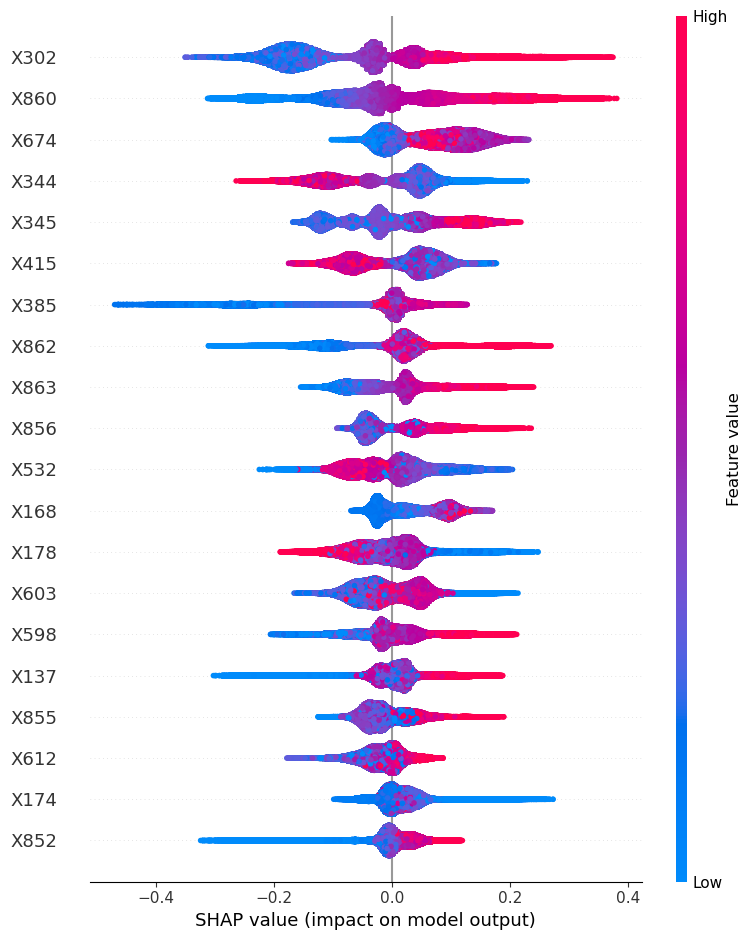


Predictions saved to submission1_1.csv
   ID  prediction
0   1    0.204331
1   2   -0.040321
2   3    0.197543
3   4   -0.067841
4   5    0.263528

Ensemble results saved to ensemble_results.csv
                      model  pearson_correlation  weight_in_final
0  Model 1 (100% Full Data)             0.502057         0.136352
1      Model 2 (90% Recent)             0.515959         0.140128
2      Model 3 (80% Recent)             0.522264         0.141840
3      Model 4 (70% Recent)             0.529606         0.143834
4      Model 5 (60% Recent)             0.536629         0.145741
5      Model 6 (50% Recent)             0.537868         0.146078
6      Model 7 (40% Recent)             0.537681         0.146027
7           Simple Ensemble             0.535161              NaN
8         Weighted Ensemble             0.535461              NaN


In [47]:
# SHAP analysis (using Model 1 as representative)
print("\nGenerating SHAP analysis...")
# Note: We need to retrain model1 for SHAP since we're outside the CV loop
X_train, X_valid, y_train, y_valid = train_test_split(train[FEATURES], train['label'], test_size=0.167, random_state=42)

model1_for_shap = XGBRegressor(**xgb_params)
model1_for_shap.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=200,
    sample_weight = sample_weights_full[X_train.index]
)
explainer = shap.TreeExplainer(model1_for_shap, feature_perturbation="tree_path_dependent", model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Save detailed results
results_data = {
    'model': [config['name'] for config in model_configs] + ['Simple Ensemble', 'Weighted Ensemble'],
    'pearson_correlation': pearson_scores + [ensemble_pearson_score, weighted_ensemble_score],
    'weight_in_final': [weight if weighted_ensemble_score > ensemble_pearson_score else 1/n_models 
                        for weight in weights] + [np.nan, np.nan]
}

ensemble_results = pd.DataFrame(results_data)
ensemble_results.to_csv("ensemble_results.csv", index=False)
print("\nEnsemble results saved to ensemble_results.csv")
print(ensemble_results)

## 2. Use lightGBM
add other feautures: https://www.kaggle.com/code/yangq369/drw-lightgbm-fold

In [48]:
def feature_engineering(df):
    # Create interaction features for df
    df['bid_ask_interaction'] = df['bid_qty'] * df['ask_qty']
    df['bid_buy_interaction'] = df['bid_qty'] * df['buy_qty']
    df['bid_sell_interaction'] = df['bid_qty'] * df['sell_qty']
    df['ask_buy_interaction'] = df['ask_qty'] * df['buy_qty']
    df['ask_sell_interaction'] = df['ask_qty'] * df['sell_qty']
    df['buy_sell_interaction'] = df['buy_qty'] * df['sell_qty']

    # Calculate spread indicators for df
    df['spread_indicator'] = (df['ask_qty'] - df['bid_qty']) / (df['ask_qty'] + df['bid_qty'] + 1e-8)

    # Volume-weighted features for df
    df['volume_weighted_buy'] = df['buy_qty'] * df['volume']
    df['volume_weighted_sell'] = df['sell_qty'] * df['volume']
    df['volume_weighted_bid'] = df['bid_qty'] * df['volume']
    df['volume_weighted_ask'] = df['ask_qty'] * df['volume']

    # NEW FEATURES - Add ratio features
    df['buy_sell_ratio'] = df['buy_qty'] / (df['sell_qty'] + 1e-8)
    df['bid_ask_ratio'] = df['bid_qty'] / (df['ask_qty'] + 1e-8)

    # NEW FEATURES - Add order flow imbalance
    df['order_flow_imbalance'] = (df['buy_qty'] - df['sell_qty']) / (df['volume'] + 1e-8)

    # NEW FEATURES - Add market pressure indicators
    df['buying_pressure'] = df['buy_qty'] / (df['volume'] + 1e-8)
    df['selling_pressure'] = df['sell_qty'] / (df['volume'] + 1e-8)

    # ADDITIONAL NEWMARKET FEATURES - Liquidity measures
    df['total_liquidity'] = df['bid_qty'] + df['ask_qty']
    df['liquidity_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['total_liquidity'] + 1e-8)
    df['relative_spread'] = (df['ask_qty'] - df['bid_qty']) / (df['volume'] + 1e-8)

    # ADDITIONAL NEW MARKET FEATURES - Trade intensity
    df['trade_intensity'] = (df['buy_qty'] + df['sell_qty']) / (df['volume'] + 1e-8)
    df['avg_trade_size'] = df['volume'] / (df['buy_qty'] + df['sell_qty'] + 1e-8)
    df['net_trade_flow'] = (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty'] + 1e-8)

    # ADDITIONAL NEW MARKET FEATURES - Market depth and activity
    df['depth_ratio'] = df['total_liquidity'] / (df['volume'] + 1e-8)
    df['volume_participation'] = (df['buy_qty'] + df['sell_qty']) / (df['total_liquidity'] + 1e-8)
    df['market_activity'] = df['volume'] * df['total_liquidity']

    # ADDITIONAL NEW MARKET FEATURES - Execution quality indicators
    df['effective_spread_proxy'] = np.abs(df['buy_qty'] - df['sell_qty']) / (df['volume'] + 1e-8)
    df['realized_volatility_proxy'] = np.abs(df['order_flow_imbalance']) * df['volume']

    # ADDITIONAL NEW MARKET FEATURES - Normalized volumes
    df['normalized_buy_volume'] = df['buy_qty'] / (df['bid_qty'] + 1e-8)
    df['normalized_sell_volume'] = df['sell_qty'] / (df['ask_qty'] + 1e-8)

    # ADDITIONAL NEW MARKET FEATURES - Complex interactions
    df['liquidity_adjusted_imbalance'] = df['order_flow_imbalance'] * df['depth_ratio']
    df['pressure_spread_interaction'] = df['buying_pressure'] * df['spread_indicator']

    # Replace any inf or -inf values with NaN, then fill NaN with 0
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    return df 

In [75]:
def pearsonr_coeff(preds, data):
    y_true = data.get_label()
    # weights = data.get_weight()
    valid_score = pearsonr(y_true, preds)[0]
    return 'pearsonr_coeff_score',valid_score,True

In [51]:
train_new = feature_engineering(train_orig)
test_new = feature_engineering(test_orig)

In [54]:
train_new.tail()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,net_trade_flow,depth_ratio,volume_participation,market_activity,effective_spread_proxy,realized_volatility_proxy,normalized_buy_volume,normalized_sell_volume,liquidity_adjusted_imbalance,pressure_spread_interaction
525882,4.164062,6.804688,39.031250,55.34375,94.3750,0.020157,0.076538,0.229004,0.288818,0.151611,...,-0.172852,0.116211,8.601562,1035.0,0.172852,16.312500,9.375000,8.132812,-0.020081,0.099548
525883,2.289062,4.058594,110.187500,67.18750,177.3750,0.016266,0.062500,0.214111,0.276367,0.146484,...,0.242432,0.035797,27.937500,1126.0,0.242432,43.000000,48.125000,16.546875,0.008675,0.173218
525884,5.238281,3.640625,70.500000,30.75000,101.2500,0.045410,0.109863,0.263672,0.329346,0.174194,...,0.392578,0.087646,11.406250,898.5,0.392578,39.750000,13.460938,8.445312,0.034393,-0.125366
525885,5.730469,4.902344,22.359375,52.18750,74.5625,0.124756,0.244141,0.408691,0.479980,0.251465,...,-0.400146,0.142578,7.011719,793.0,0.400146,29.828125,3.902344,10.648438,-0.057037,-0.023346
525886,3.925781,3.865234,86.562500,217.12500,303.7500,0.368652,0.665527,0.867676,0.951660,0.491211,...,-0.429688,0.025650,39.000000,2366.0,0.429688,130.500000,22.046875,56.187500,-0.011024,-0.002214


In [ ]:
selected_features2 = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume", "bid_ask_interaction", "bid_buy_interaction", "bid_sell_interaction", "ask_buy_interaction", "ask_sell_interaction"
]

train2 = train_new[selected_features2 + ["label"]].copy()
test2 = test_new[selected_features2].copy()

In [52]:
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "regression",       
    "metric": "mae",                 
    "colsample_bytree": 0.55,
    "learning_rate": 0.021,
    "min_child_samples": 32,
    "min_child_weight": 0.15,
    'max_depth':-1,
    "n_jobs": -1,
    "num_leaves":64,
    "random_state": 42,
    "reg_alpha": 80,
    "reg_lambda": 100,
    "subsample": 0.85,
    "verbosity": 1
}

In [77]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
X_test = test[FEATURES]

oof_preds2 = np.zeros(len(train))
test_preds2 = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print("#" * 25)
    print(f"### Fold {i + 1}")
    print("#" * 25)

    X_train = train.iloc[train_idx][FEATURES]
    y_train = train.iloc[train_idx]["label"]
    X_valid = train.iloc[valid_idx][FEATURES]
    y_valid = train.iloc[valid_idx]["label"]

    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False).construct()
    valid_data = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False).construct()

    model2 = lgb.train(
        lgb_params,
        train_data,
        num_boost_round = 150,
        valid_sets = [valid_data],
        feval = pearsonr_coeff,
        callbacks = [lgb.callback.log_evaluation(period = 50)]
    )

    oof_preds2[valid_idx] = model2.predict(X_valid)
    test_preds2 += model2.predict(X_test)

pearson_score2 = pearsonr(train["label"], oof_preds2)[0]
print("Final Pearson Correlation = ", pearson_score2)

test_preds2 /= FOLDS
save_model(model2, os.path.join(CFG.main_path, 'lightGBM'))

#########################
### Fold 1
#########################
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 25
[LightGBM] [Info] Start training from score 0.037167
[50]	valid_0's l1: 0.608578	valid_0's pearsonr_coeff_score: 0.584766
[100]	valid_0's l1: 0.583675	valid_0's pearsonr_coeff_score: 0.637797
[150]	valid_0's l1: 0.562667	valid_0's pearsonr_coeff_score: 0.676058
#########################
### Fold 2
#########################
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637

In [79]:
sample["prediction"] = test_preds2
sample.to_csv("submission2.csv", index=False)
sample.tail()

,ID,prediction
538145,538146,-0.041533
538146,538147,-0.248675
538147,538148,0.067002
538148,538149,0.003933
538149,538150,0.157171


In [81]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
X_test = test2[selected_features2]

oof_preds22 = np.zeros(len(train2))
test_preds22 = np.zeros(len(test2))

for i, (train_idx, valid_idx) in enumerate(kf.split(train2)):
    print("#" * 25)
    print(f"### Fold {i + 1}")
    print("#" * 25)

    X_train = train2.iloc[train_idx][selected_features2]
    y_train = train2.iloc[train_idx]["label"]
    X_valid = train2.iloc[valid_idx][selected_features2]
    y_valid = train2.iloc[valid_idx]["label"]

    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False).construct()
    valid_data = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False).construct()

    model22 = lgb.train(
        lgb_params,
        train_data,
        num_boost_round = 150,
        valid_sets = [valid_data],
        feval = pearsonr_coeff,
        callbacks = [lgb.callback.log_evaluation(period = 50)]
    )

    oof_preds22[valid_idx] = model22.predict(X_valid)
    test_preds22 += model22.predict(X_test)

pearson_score22 = pearsonr(train2["label"], oof_preds22)[0]
print("Final Pearson Correlation = ", pearson_score22)

test_preds22 /= FOLDS
save_model(model22, os.path.join(CFG.main_path, 'lightGBM_2'))

sample["prediction"] = test_preds22
sample.to_csv("submission22.csv", index=False)
sample.tail()

#########################
### Fold 1
#########################
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 30
[LightGBM] [Info] Start training from score 0.037167
[50]	valid_0's l1: 0.608391	valid_0's pearsonr_coeff_score: 0.587031
[100]	valid_0's l1: 0.583735	valid_0's pearsonr_coeff_score: 0.635081
[150]	valid_0's l1: 0.563044	valid_0's pearsonr_coeff_score: 0.67325
#########################
### Fold 2
#########################
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650

,ID,prediction
538145,538146,0.008451
538146,538147,-0.261293
538147,538148,0.054653
538148,538149,-0.139024
538149,538150,0.102673


## Thoughts:
1. Train blender (ridge regression): https://www.kaggle.com/competitions/drw-crypto-market-prediction/discussion/581075
2. CatBoost, LightGBM, XGBoost, Blender --> Ensemble model
3. Amazon framework (AutoGluon)
4. Quantile regression forest